# LAB06 Assigment




### Exercise 1 Linear Discriminant Analysis from Scratch using numpy (50 points )
- <font size=4> Complete the missing code in the LDA class below<font>

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt


class LDA:
    #n_components:Number of components (<= min(n_classes - 1, n_features)) for dimensionality reduction.
    def __init__(self, n_components=None):
        
        self.n_components = n_components
        self.eigenvalues = None
        self.eigenvectors = None

    def fit(self, X, y):
        if self.n_components is None or self.n_components > X.shape[1]:
            n_components = X.shape[1]
        else:
            n_components = self.n_components
       
        n_features = np.shape(X)[1]
        labels = np.unique(y)
  
        # Within class scatter matrix
        # Complete code for calculating S_W
        
        S_W = np.zeros((n_features, n_features)) # 预申请内存。
        for c in labels:
            X_c = X[y == c] # 这是一个矩阵，取出了所有属于c类的样本
            u_c = np.mean(X_c, axis=0) # 对每一列求平均值，得到一个行向量。
            # 公式里面是列向量(x-u)@(x-u).T求和
            # 这里实现方式是 很多行向量 X-u转置为很多列向量，然后矩阵乘法完成求和
            # 比如[列(x1-u1), 列(x2-u2) ]@[行(x1-u1), 行(x2-u2)]T 
            # = 列(x1-u1)行(x1-u1) + 列(x2-u2)行(x2-u2) = 多个大矩阵相加
            S_c = (X_c - u_c).T@(X_c - u_c) 
            S_W += S_c

        # Between class scatter matrix
        # Complete code for calculating S_B
        # S_B = np.zeros((n_features, n_features)) # 预申请内存。
        # u = np.mean(X, axis=0) # 对每一列求平均值，得到一个行向量。这个是整个数据集的均值。
        us = np.zeros((len(labels), n_features)) # 预申请内存。收集所有类别的均值。
        for c in labels:
            X_c = X[y == c]
            u_c = np.mean(X_c, axis=0) # 对每一列求平均值，得到一个行向量。这个是c类的均值。
            us[c] = u_c
        u = np.mean(us, axis=0)
        S_B = (us - u).T@(us - u) # 屡试不爽，用矩阵乘法完成求和。
        
        # Determine SW^-1 * SB by calculating inverse of SW
        S_W_inv = np.linalg.pinv(S_W)
        
        # Get eigenvalues and eigenvectors of SW^-1 * SB
        eigenvalues, eigenvectors = np.linalg.eig(S_W_inv @ S_B)    

        # Sort the eigenvalues and corresponding eigenvectors from largest
        # to smallest eigenvalue and select the first n_components
        idx = eigenvalues.argsort()[::-1]
        eigenvalues = eigenvalues[idx][:n_components]
        eigenvectors = eigenvectors[:, idx][:, :n_components]
  
        self.eigenvalues = eigenvalues
        self.eigenvectors = eigenvectors
        return self #链式调用
  
    def fit_transform(self, X, y):
        return self.fit(X, y).transform(X)
  
    def transform(self, X):
        return X @ self.eigenvectors

- <font size=4> Dimensionality reduction visualization<font>

C:\Users\YeCanming\AppData\Local\Temp\ipykernel_16408\3949694527.py:34: MatplotlibDeprecationWarning: The w_zaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use zaxis instead.
  ax.w_zaxis.set_ticklabels([])
C:\Users\YeCanming\AppData\Local\Temp\ipykernel_16408\3949694527.py:40: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 12


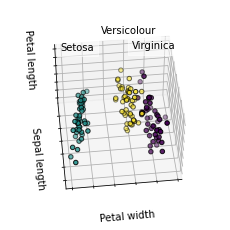

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets

np.random.seed(5)


iris = datasets.load_iris()
X = iris.data
y = iris.target
pca = LDA(n_components=3)
pca.fit(X, y)
X = pca.transform(X)

fig = plt.figure(1, figsize=(12, 3))
ax = fig.add_subplot(111, projection="3d", elev=48, azim=1344) # azim改为1344,看得更清楚
ax.set_position([0, 0, 0.95, 1])
for name, label in [('Setosa', 0), ('Versicolour', 1), ('Virginica', 2)]:    
    ax.text3D(
        X[y == label, 0].mean(),
        X[y == label, 1].mean(),
        X[y == label, 2].mean() + 2,
        name,
        horizontalalignment="center",
        bbox=dict(alpha=0.5, edgecolor="w", facecolor="w"),
    )
# Reorder the labels to have colors matching the cluster results
y = np.choose(y, [1, 2, 0]).astype(float)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, 
        edgecolor='k')

ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

ax.set_xlabel("Petal width")
ax.set_ylabel("Sepal length")
ax.set_zlabel("Petal length")
# ax.set_title("Ground Truth")
ax.dist = 12

plt.show()

### Exercise 2 Recognize handwritten numbers with LDA (50 points ). 

Your task in this section is to recognize handwritten numbers, and you can use the linear discriminant analysis model from the Scikit-Learn library to fit, evaluate, and predict them.

<font color='red' size=4>Note that your accuracy in this section will directly determine your score.</font>

### Loading the MNIST Dataset


In [2]:
########### Write Your Code Here ###########
from sklearn.datasets import fetch_openml
import numpy as np
# minist = fetch_openml("mnist_784", version=1, return_X_y=False, as_frame=False) # 下载
# minist = fetch_openml("mnist_784", data_home='./datasets', version=1, return_X_y=False, as_frame=False) # 下载太慢了，改成本地读取。
# minist = fetch_openml("MNIST Original", data_home='./datasets') 
# minist = fetch_openml("mnist_784", data_home='./datasets') 

# 下载太慢了，改成本地读取。
# sklearn有bug，目前不能用data_home参数，所以我们用joblib自己缓存到目录。
import joblib
from joblib import memory
memory = joblib.Memory('./tmp')

fetch_openml_cached = memory.cache(fetch_openml)

minist = fetch_openml_cached("mnist_784", version=1, return_X_y=False, as_frame=False)

 Traceback (most recent call last):
  File "d:\EnglishStandardPath\DevProgramsFile\Python\python39\lib\site-packages\joblib\memory.py", line 516, in _cached_call
    out = self.store_backend.load_item(
  File "d:\EnglishStandardPath\DevProgramsFile\Python\python39\lib\site-packages\joblib\_store_backends.py", line 170, in load_item
    item = numpy_pickle.load(f)
  File "d:\EnglishStandardPath\DevProgramsFile\Python\python39\lib\site-packages\joblib\numpy_pickle.py", line 577, in load
    obj = _unpickle(fobj)
  File "d:\EnglishStandardPath\DevProgramsFile\Python\python39\lib\site-packages\joblib\numpy_pickle.py", line 506, in _unpickle
    obj = unpickler.load()
  File "d:\EnglishStandardPath\DevProgramsFile\Python\python39\lib\pickle.py", line 1212, in load
    dispatch[key[0]](self)
  File "d:\EnglishStandardPath\DevProgramsFile\Python\python39\lib\site-packages\joblib\numpy_pickle.py", line 344, in load_build
    self.stack.append(array_wrapper.read(self))
  File "d:\EnglishStandar

________________________________________________________________________________
[Memory] Calling sklearn.datasets._openml.fetch_openml...
fetch_openml('mnist_784', version=1, return_X_y=False, as_frame=False)


In [4]:
dir(minist)

['DESCR',
 'categories',
 'data',
 'details',
 'feature_names',
 'frame',
 'target',
 'target_names',
 'url']

In [5]:
[i.shape for i in (minist.data, minist.target)]+[minist.target_names, minist.feature_names[:5]]

[(70000, 784),
 (70000,),
 ['class'],
 ['pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5']]

In [6]:
minist.target_names = minist.categories = np.unique(minist.target).astype('str')
minist.target_names

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype='<U1')

###  Visualization of MINIST

In [7]:
# Visualize MINIST
########### Write Your Code Here ###########
# del draw_scatter
# del visualization
import visualization
# from visualization import *
import seaborn as sns

# sns.displot(minist.target)
############################################

In [ ]:
import pandas as pd
dt = np.hstack((minist.data, minist.target.reshape(-1, 1)))
df = pd.DataFrame(dt)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9


In [ ]:
M = len(minist.feature_names)
df=df.astype('int')
df.dtypes
df[M] = df[M].astype('category')
df.dtypes

0         int32
1         int32
2         int32
3         int32
4         int32
         ...   
780       int32
781       int32
782       int32
783       int32
784    category
Length: 785, dtype: object

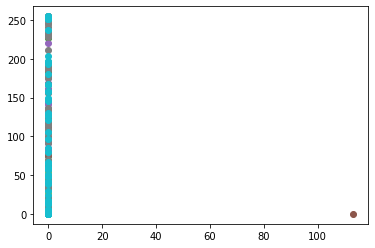

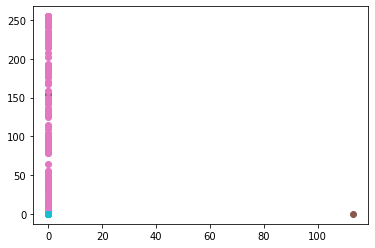

In [ ]:
visualization.draw_scatter(M//2, M//2+3, minist)
visualization.draw_scatter(M//2, M//10, minist)
# sns.relplot(
#     data=dt, kind='scatter', 
#     x=M//2, y=M//2+1, 
#     # hue=M, style=M
# )

## Experiment
1. 搭建实验框架

In [ ]:
# 先采个样，不然太慢了。
indexes = np.random.choice(len(minist.data), 3000)
X = minist.data[indexes, :]
y = minist.target[indexes]
X.shape, y.shape

((3000, 784), (3000,))

In [ ]:
from fast_evaluation import *
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
def just_e(list, cross=True, print_it=True):
    q = evaluate(make_pipeline(*list), X, y, cross)
    if print_it:
        print(q)
    return q

2. baseline

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
just_e([LinearDiscriminantAnalysis()])

0.788


0.788

3. 前缀分析的效果比较

In [ ]:
from sklearn.preprocessing import MinMaxScaler, Binarizer, PolynomialFeatures, StandardScaler
just_e([MinMaxScaler(), LinearDiscriminantAnalysis()])  #作用不大
just_e([StandardScaler(), LinearDiscriminantAnalysis()])  #作用不大
just_e([Binarizer(threshold=0.5), LinearDiscriminantAnalysis()])  # 二值化有显著作用。
just_e([MinMaxScaler(), Binarizer(threshold=0.5), LinearDiscriminantAnalysis()]) # MinMax有负作用。

0.7728888888888887
0.776888888888889
0.8088888888888889
0.7737777777777778


0.7737777777777778

In [ ]:
from sklearn.preprocessing import *
prefixes = [QuantileTransformer(), PowerTransformer(), RobustScaler(), MaxAbsScaler(), Normalizer()]
for prefix in prefixes:
    q = just_e([prefix, LinearDiscriminantAnalysis()])

0.7906666666666666
0.8026666666666665
0.7684444444444445
0.78
0.8075555555555555


4. 后缀模型的效果比较

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neighbors import KNeighborsClassifier
# baseline 是0.8075 (默认使用Binarizer)
postfixes = [GaussianNB(), SVC(), MLPClassifier(), DecisionTreeClassifier(), GaussianProcessClassifier(), KNeighborsClassifier()]
for postfix in postfixes:
    q = just_e([Binarizer(threshold=0.5), postfix], print_it=False)
    print(f'{postfix.__class__.__name__}: {q}')
    q = just_e([Binarizer(threshold=0.5),LinearDiscriminantAnalysis(), postfix], print_it=False)
    print(f'LDA+{postfix.__class__.__name__}: {q}')

d:\EnglishStandardPath\DevProgramsFile\Python\python39\lib\site-packages\sklearn\naive_bayes.py:488: RuntimeWarning: divide by zero encountered in log
  n_ij = -0.5 * np.sum(np.log(2.0 * np.pi * self.var_[i, :]))
d:\EnglishStandardPath\DevProgramsFile\Python\python39\lib\site-packages\sklearn\naive_bayes.py:489: RuntimeWarning: divide by zero encountered in divide
  n_ij -= 0.5 * np.sum(((X - self.theta_[i, :]) ** 2) / (self.var_[i, :]), 1)
d:\EnglishStandardPath\DevProgramsFile\Python\python39\lib\site-packages\sklearn\naive_bayes.py:489: RuntimeWarning: invalid value encountered in divide
  n_ij -= 0.5 * np.sum(((X - self.theta_[i, :]) ** 2) / (self.var_[i, :]), 1)
d:\EnglishStandardPath\DevProgramsFile\Python\python39\lib\site-packages\sklearn\naive_bayes.py:488: RuntimeWarning: divide by zero encountered in log
  n_ij = -0.5 * np.sum(np.log(2.0 * np.pi * self.var_[i, :]))
d:\EnglishStandardPath\DevProgramsFile\Python\python39\lib\site-packages\sklearn\naive_bayes.py:489: RuntimeWar

GaussianNB: 0.10044444444444445
LDA+GaussianNB: 0.812888888888889
SVC: 0.9302222222222222
LDA+SVC: 0.8039999999999999
MLPClassifier: 0.8964444444444444


d:\EnglishStandardPath\DevProgramsFile\Python\python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
d:\EnglishStandardPath\DevProgramsFile\Python\python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
d:\EnglishStandardPath\DevProgramsFile\Python\python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
d:\EnglishStandardPath\DevProgramsFile\Python\python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

LDA+MLPClassifier: 0.7991111111111111
DecisionTreeClassifier: 0.7462222222222222
LDA+DecisionTreeClassifier: 0.6844444444444444
GaussianProcessClassifier: 0.8155555555555555
LDA+GaussianProcessClassifier: 0.8022222222222222
KNeighborsClassifier: 0.9106666666666667
LDA+KNeighborsClassifier: 0.7911111111111111


GaussianNB: 0.10044444444444445
LDA+GaussianNB: 0.812888888888889
SVC: 0.9302222222222222
LDA+SVC: 0.8039999999999999
MLPClassifier: 0.8964444444444444
LDA+MLPClassifier: 0.7991111111111111
DecisionTreeClassifier: 0.7462222222222222
LDA+DecisionTreeClassifier: 0.6844444444444444
GaussianProcessClassifier: 0.8155555555555555
LDA+GaussianProcessClassifier: 0.8022222222222222
KNeighborsClassifier: 0.9106666666666667
LDA+KNeighborsClassifier: 0.7911111111111111
实验数据分析：
1. LDA改进了Gaussian，其他都是降低了效果
2. SVC最强。KNN次之。

In [ ]:
just_e([KNeighborsClassifier()])

0.9093333333333333


0.9093333333333333

In [ ]:
## 最后挑个参数就行了。
import geatpy as ea
from sklearn.model_selection import cross_val_score
@ea.Problem.single
def evalVars(Vars):  # 定义目标函数（含约束）
    model = make_pipeline(Binarizer(threshold=Vars[0]), 
                          KNeighborsClassifier(int(Vars[1])))
    # print('开始')
    f = cross_val_score(model, X_train, y_train, cv=2).mean()
    print('结束')
    CV = 0 
    return f, CV

lb = [0, 1]
ub = [1, 100] 
# lb = [1, np.finfo(np.float32).min] 
# ub = [1, np.finfo(np.float32).max] 
varTypes = [0, 1]
dim = 2
problem = ea.Problem(name='演化计算求解K近邻分类器最优参数',
                     M=1,  # 目标维数
                     maxormins=[-1],  # 目标最小最大化标记列表，1：最小化该目标；-1：最大化该目标
                     Dim=dim,  # 决策变量维数
                     varTypes=varTypes,  # 决策变量的类型列表，0：实数；1：整数
                     lb=lb,  # 决策变量下界
                     ub=ub,  # 决策变量上界
                     evalVars=evalVars)
# 构建算法
algorithm = ea.soea_SEGA_templet(problem,
                                 ea.Population(Encoding='RI', NIND=16),
                                #  MAXGEN=80,  # 最大进化代数。
                                 MAXGEN=180,  # 最大进化代数。
                                 logTras=1,  # 表示每隔多少代记录一次日志信息，0表示不记录。
                                 trappedValue=1e-8,  # 单目标优化陷入停滞的判断阈值。
                                #  trappedValue=1e-6,  # 单目标优化陷入停滞的判断阈值。
                                 maxTrappedCount=100)  # 进化停滞计数器最大上限值。
                                #  maxTrappedCount=10)  # 进化停滞计数器最大上限值。
# 求解
res = ea.optimize(algorithm, prophet=np.array([[0.5, 5],    
                                                [0.7, 3], 
]), 
                  seed=128, verbose=True, drawing=1, outputMsg=True, drawLog=True, saveFlag=True, dirName='result')

## Fit and Evaluate model on the entire dataset

In [ ]:
########### Write Your Code Here ###########
X_train, X_test, y_train, y_test = train_test_split(minist.data, minist.target)
pipeline = make_pipeline(Binarizer(threshold=0.5), KNeighborsClassifier())
pipeline.fit(X_train, y_train)
############################################

Pipeline(steps=[('binarizer', Binarizer(threshold=0.5)),
                ('kneighborsclassifier', KNeighborsClassifier())])

In [ ]:
pipeline.score(X_test, y_test)

0.9689142857142857

### Exercise 3: Qustions
- Q1:What are the advantages and disadvantages of LDA?
优点：
- 是有监督学习算法，目的明确，可以反映样本间的差异。

缺点：
- 不适合对非高斯分布样本进行降维，这是LDA fundamental的假设。
- 只能降低到`类别数-1`个维度。
- 不适合非连续性的特征。


类别数-1`个维度。
- 不适合非连续性的特征。


- Q2 LDA can be used for dimensionality reduction, so can PCA. Please tell the difference between them?

LDA是多维空间中的数据分类问题的一个有监督分类模型或者预处理方法，它将d维数据投影到d-1维数据进行处理，使得投影之后类内方差最小，类间方差最大。

PCA是一种无监督的降维方法，它将d维数据投影到k维数据进行处理，使得投影之后数据的方差最大，其中k<d。由于没有监督，所以没有明确的目的，只是说整个数据的方差最大。
